In [1]:
from __future__ import division, print_function

import sys
import time
import copy
import datetime

import numpy as np

from scipy import interpolate

from astropy import units as u
from astropy import constants as cnst

from astropy.coordinates import SkyCoord, Distance
from astropy.wcs import WCS
from astropy.io import fits
from astropy import modeling

from astroquery.irsa_dust import IrsaDust

import emceemr
from emceemr import priors
import rgbmcmr

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams


rcParams['figure.figsize'] = (16, 10)
rcParams['image.interpolation'] = 'none'
rcParams['image.origin'] = 'lower'

In [3]:
def save_pub_figure(basename, figdir='figures', fig=None):
    import os
    if fig is None:
        fig = plt.gcf()
    plt.savefig(os.path.join(figdir, basename+'.pdf'))
    plt.savefig(os.path.join(figdir, basename+'.png'))
    
def reprocess_triangle_for_pub(fig, labelsize=18, titlesize=None, tcklabelsize=None):
    for ax in fig.axes:
        for txt in (ax.title, ax.xaxis.label, ax.yaxis.label):
            #boost the sizes of the labels
            txt.set_fontsize(labelsize)
            
            #strip out newlines unless they are before '='s
            if '=' not in txt.get_text():
                txt.set_text(txt.get_text().replace('\n', ''))
        if titlesize is not None:
            ax.title.set_fontsize(titlesize)
                
        if tcklabelsize is not None:
            for tl in ax.xaxis.get_majorticklabels()  + ax.yaxis.get_majorticklabels():
                tl.set_fontsize(tcklabelsize)

# Pisc A

In [4]:
d = np.loadtxt('PiscA_dolphot/piscA')
wcs = WCS(fits.getheader('PiscA_dolphot/PiscA_F606W_build_drc.chip1.fits'))

#object is roughly here
x0 = 3650
y0 = 5400

#control area
xc = 3500
yc = 3000

sc0 = SkyCoord.from_pixel(x0, y0, wcs)
ebvmap = IrsaDust.get_images(sc0,2*u.degree, 'ebv')[0][0].data
ebv = ebvmap[ebvmap.shape[0]//2, ebvmap.shape[0]//2]
A606W = ebv*2.471 # from S & F 11
A814W = ebv*1.526 # from S & F 11
A606W, A814W

# only use good stars
ds = d[d[:, 10]<2]

m606 = ds[:,15] - A606W
m606e = ds[:,17]
m814 = ds[:,28] - A814W
m814e = ds[:,30]
dpx_dwarf = np.hypot(x0-ds[:,2],y0-ds[:,3])
dpx_control = np.hypot(xc-ds[:,2],yc-ds[:,3])

ce = np.hypot(m606e, m814e)
me = m814e
c = m606-m814
m = m814

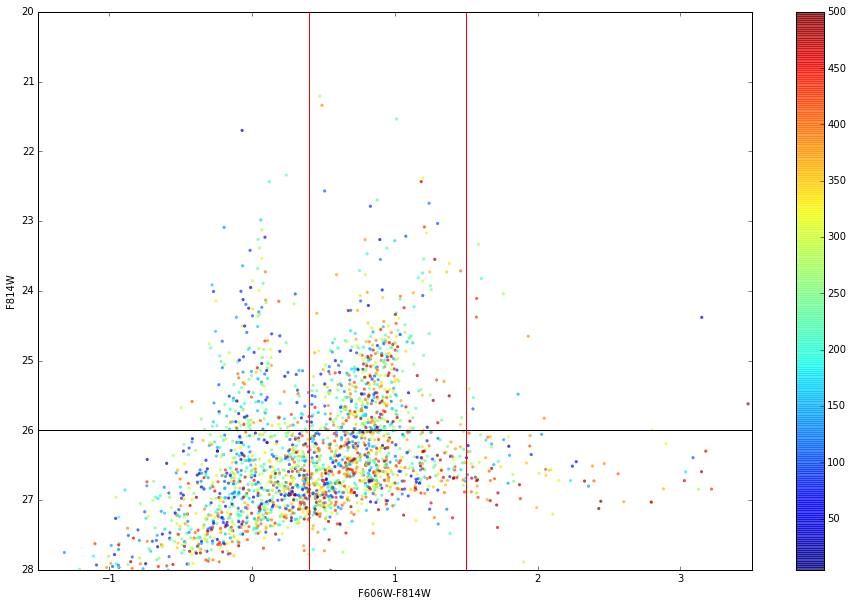

In [5]:
nearmsk = dpx_dwarf < 500

clims = (.4, 1.5)
mlim  = 26

plt.scatter(c[nearmsk], m[nearmsk], c=dpx_dwarf[nearmsk], s=10, edgecolor='none', alpha=.7)
plt.colorbar()
plt.xlim(-1.5, 3.5)
plt.ylim(28, 20)
plt.xlabel('F606W-F814W')
plt.ylabel('F814W')

for clim in clims:
    plt.axvline(clim, color='r')

plt.axhline(mlim, color='k')

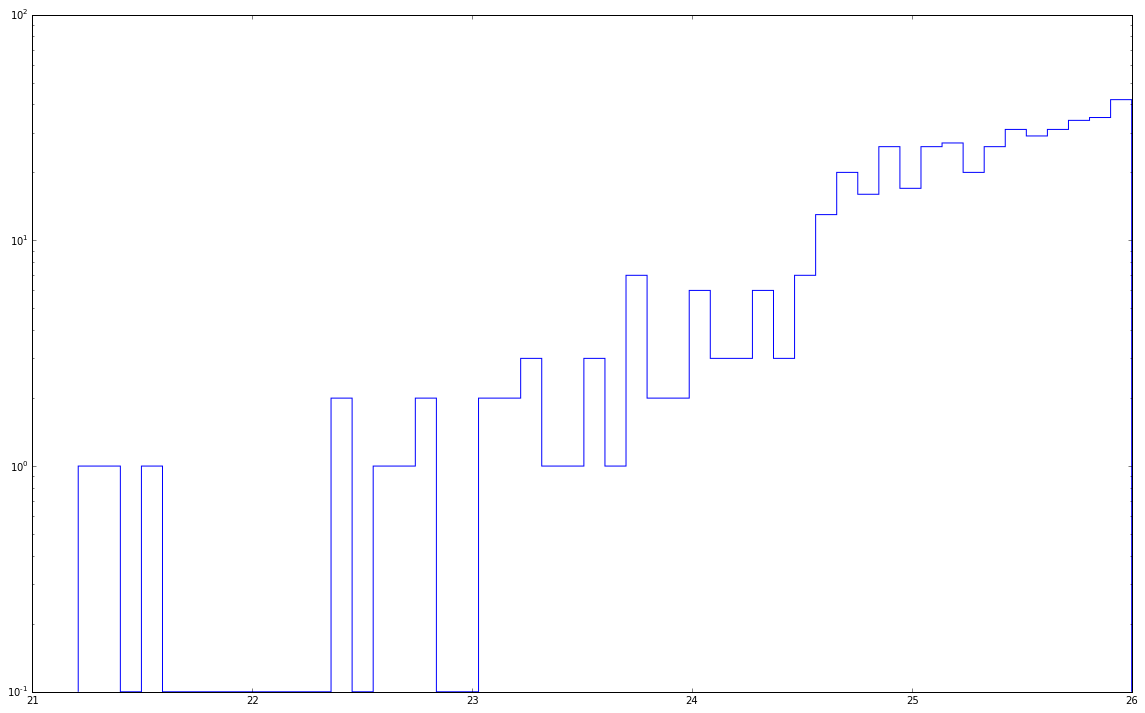

In [6]:
rgbmsk = nearmsk&(clims[0]<c)&(c<clims[1])&(m<mlim)&(m>20)
plt.hist(m[rgbmsk],bins=50, histtype='step',log=True)
plt.tight_layout()

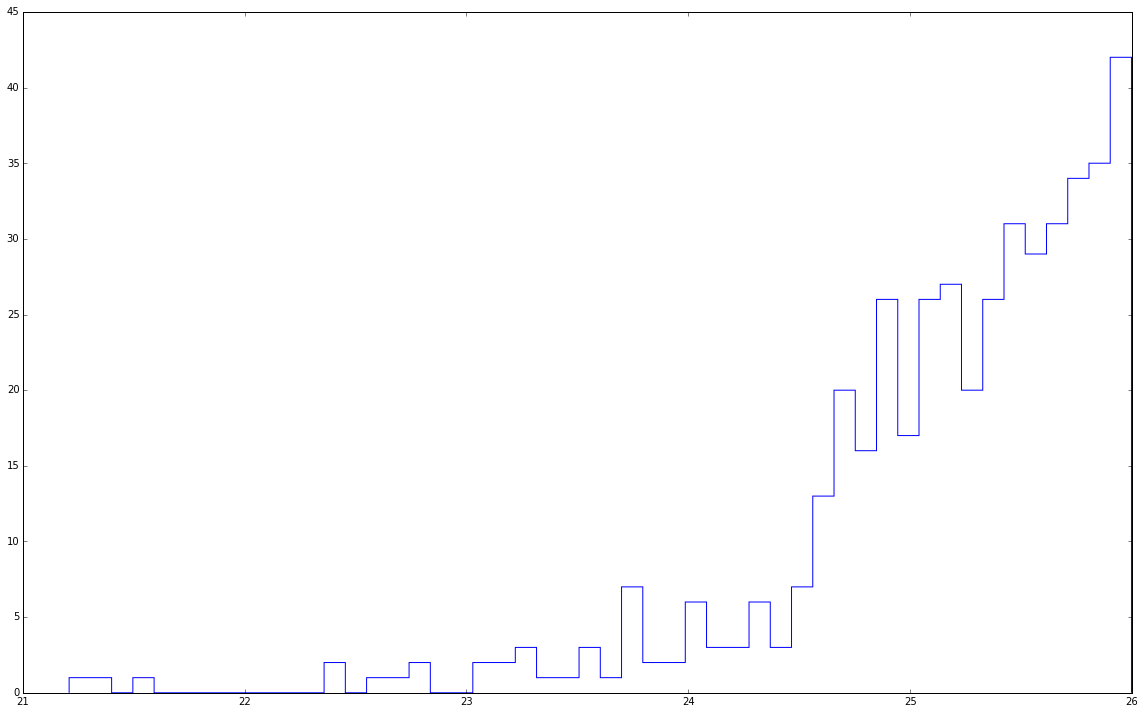

In [7]:
rgbmsk = nearmsk&(clims[0]<c)&(c<clims[1])&(m<mlim)&(m>20)
plt.hist(m[rgbmsk],bins=50, histtype='step',log=False)
plt.tight_layout()

In [8]:
nagb = np.sum((m[rgbmsk]>21)&(m[rgbmsk]<24.6))
nrgb = np.sum((m[rgbmsk]<26)&(m[rgbmsk]>24.6))
nagb,nrgb, nagb/(nagb+nrgb)

(66, 388, 0.14537444933920704)

## Baseline model with no uncfuncs/completeness 

Took 40.3881790638 sec
Acors:
tipmag: 48.5334109093
alphargb: 45.8491327754
alphaother: 36.9207981026
fracother: 40.8808322966
Acceptance Fractions:
[ 0.5892,  0.6096,  0.5846,  0.605 ,  0.6024,  0.5874,  0.5914,  0.6002,
  0.5882,  0.5908,  0.5874,  0.5858,  0.594 ,  0.587 ,  0.6016,  0.5976]


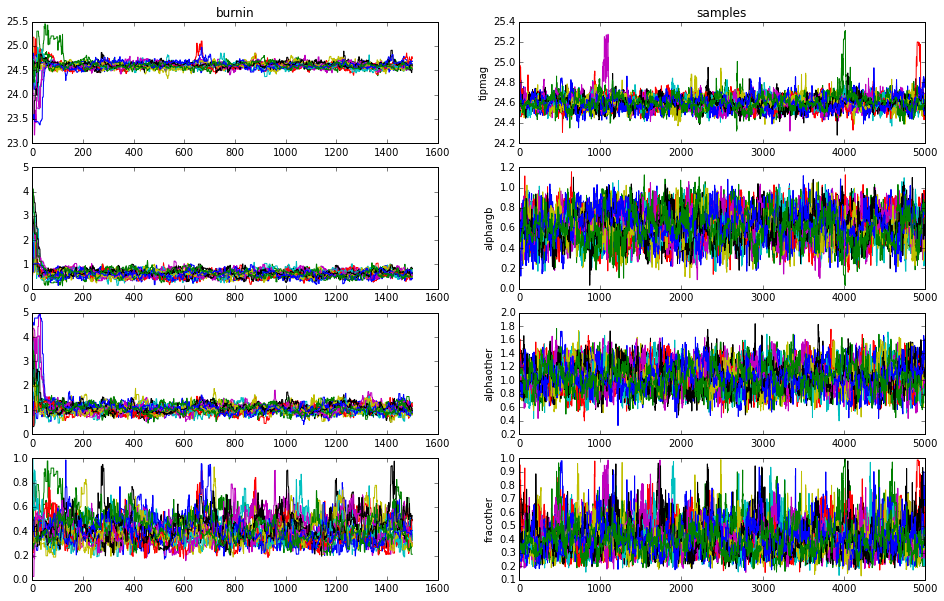

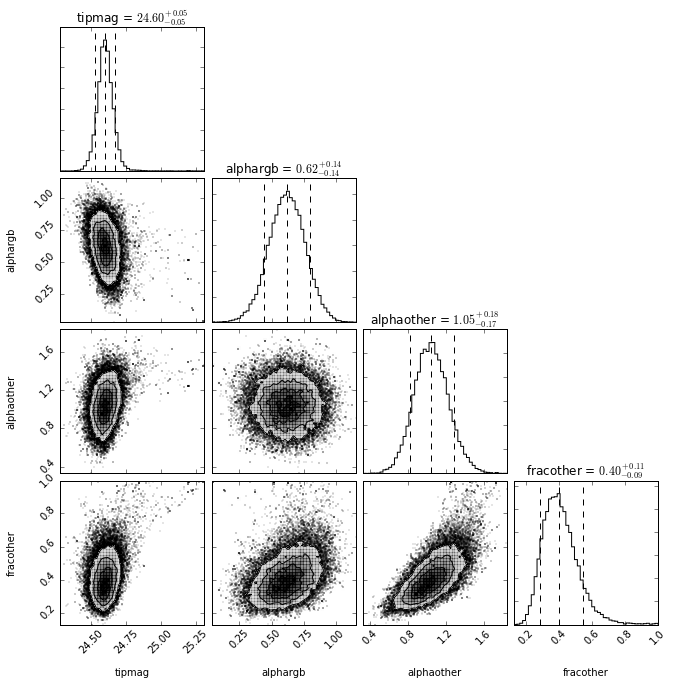

In [9]:
pris_base = dict(tipmag=priors.UniformPrior(23, 25.5),
            alphargb=priors.UniformPrior(0, 5), 
            alphaother=priors.UniformPrior(0, 5),
            fracother=priors.UniformPrior(0,1))

modA_base = rgbmcmr.RGBModel(m[rgbmsk], me[rgbmsk], priors=pris_base)

st = time.time()
samplerA_base = modA_base.initialize_and_sample(5000, burnin=1500)
et = time.time()
print('Took',et-st,'sec')

plt.figure()
emceemr.plot_chains(modA_base, samplerA_base)
plt.figure()
emceemr.triangle_plot(modA_base, samplerA_base, quantiles=[.1, .5, .9], show_titles=True, verbose=False)

print(emceemr.sampler_info_string(modA_base, samplerA_base))

## Try with the uncfunc approach 

In [10]:
#median absolute deviation from ASTs for piscA
madmodelA = modeling.models.Legendre1D(20, c0=-3954355396.3633738, c1=1353694208.4087687, c2=-124848799.79526304, c3=4897226.378521032, c4=-57041.00249220571, c5=-1549.1100474853888, c6=30.190195895799725, c7=1.1368681316643618, c8=-0.03563103282644921, c9=6.0712498989515646e-05, c10=4.892644246415783e-06, c11=8.248737934921185e-08, c12=-2.3350690477921424e-09, c13=-1.8352224226398223e-11, c14=5.350673251357965e-13, c15=2.4468515243894513e-15, c16=2.6121935517894807e-17, c17=-4.622081469223215e-18, c18=8.23871918441632e-20, c19=-6.005849952016176e-22, c20=1.6539943309668438e-24)
uncfuncA = madmodelA.copy()
uncfuncA.parameters *= 1.483 # works only b/c polynomials are linear

def complfuncA(mag): #logistic function is a good fit to completeness
    x0=28.11463766268196
    w=-0.546193490253588
    t = (mag-x0)/w
    return 1/(1+np.exp(-t))

def biasfuncA(mag):
    # get these from UnivariateSpline._eval_args
    spl_eval_args = (np.array([ 21.04,  21.04,  21.04,  21.04,  25.04,  27.04,  28.  ,  28.24,
                     28.48,  28.64,  28.72,  28.96,  28.96,  28.96,  28.96]),
                     np.array([  2.27431926e-04,  -1.32821783e-02,   2.46137242e-03,
                     -6.86495474e-02,  -3.29464037e-01,   2.55491886e-03,
                      1.95396586e-02,   3.14164071e-01,   4.38917629e-01,
                      1.50361261e+00,   5.16925592e+00,   0.00000000e+00,
                      0.00000000e+00,   0.00000000e+00,   0.00000000e+00]),
                      3)
    return -interpolate.splev(mag, spl_eval_args)

In [10]:
pris = dict(tipmag=priors.UniformPrior(23, 25.5),
            alphargb=priors.UniformPrior(0, 3), 
            alphaother=priors.UniformPrior(0, 3),
            fracother=priors.UniformPrior(0,1))

modA_uncfunc = rgbmcmr.RGBModel(m[rgbmsk], priors=pris,
                                funcmags=rgbmcmr.RGBModel.AutoFuncmags(21.005, 29, 0.125),
                                uncfunc=uncfuncA, biasfunc=biasfuncA, complfunc=complfuncA)

nthreads = 4
burnin = 1500
nsamples = 5000
len(modA_uncfunc.funcmags)  # useful because time to run scales with this

2375

In [11]:
#experimental timing run
nsample_test = 24
nburnin_test = 12
nall_test = nsample_test + nburnin_test
nall = burnin+nsamples

st = time.time()
sampler = modA_uncfunc.initialize_and_sample(nsample_test, burnin=nburnin_test, threads=nthreads)
et = time.time()
dt = (et - st)*u.second
    
print(nall_test, 'samples took', dt, 'which scales up to',nall,'samples in',(dt*nall/nall_test).to(u.minute))

36 samples took 16.6696748734 s which scales up to 6500 samples in 50.1633734615 min


Starting at 2015-12-15 14:19:20.386620
Took 3175.68635702 sec
Acors:
tipmag: 44.9875480501
alphargb: 44.206060682
alphaother: 42.3368431319
fracother: 52.2809736182
Acceptance Fractions:
[ 0.5932,  0.5858,  0.5918,  0.5932,  0.5804,  0.5744,  0.5872,  0.5858,
  0.6138,  0.5858,  0.5902,  0.5902,  0.596 ,  0.5824,  0.5932,  0.5864]


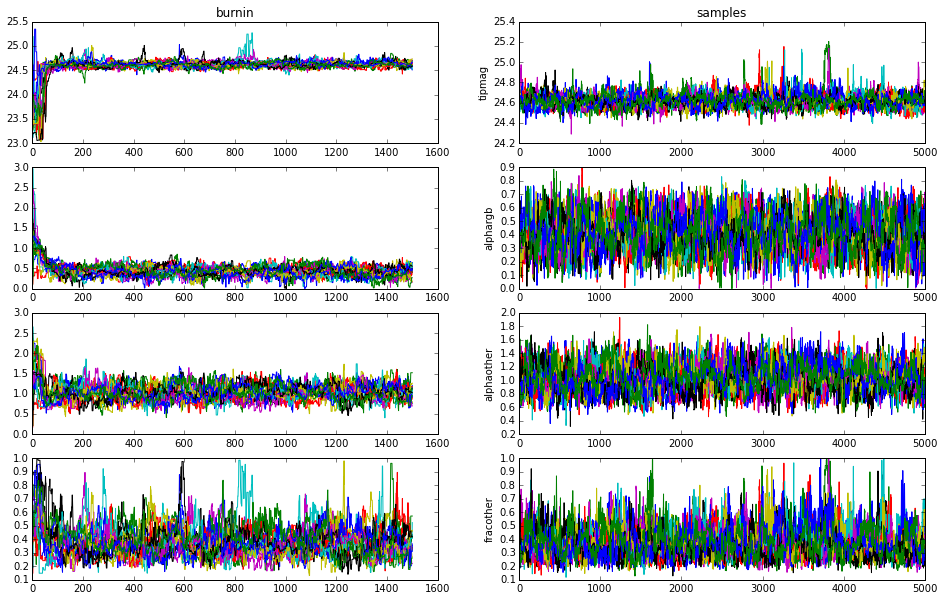

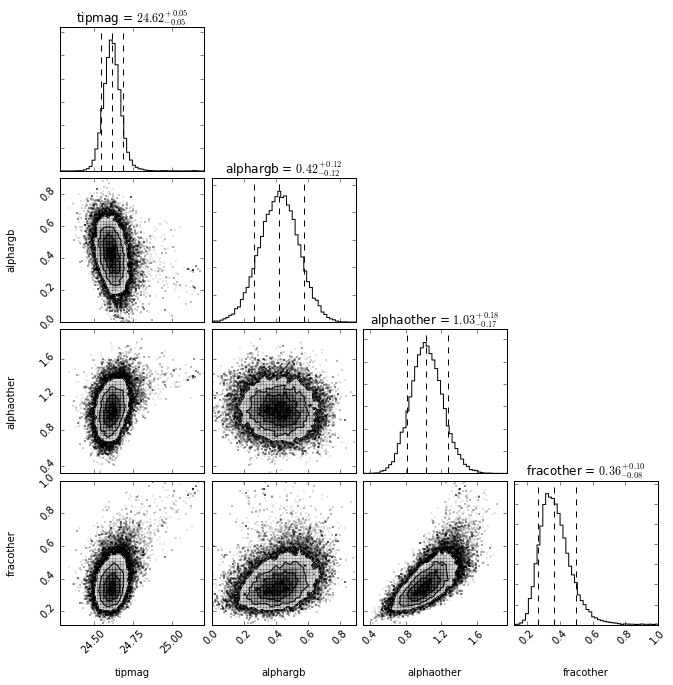

In [12]:
print('Starting at', datetime.datetime.now())
sys.stdout.flush()

st = time.time()
samplerA_uncfunc = modA_uncfunc.initialize_and_sample(nsamples, burnin=burnin, threads=nthreads)
et = time.time()
print('Took',et-st,'sec')

plt.figure()
emceemr.plot_chains(modA_uncfunc, samplerA_uncfunc)
plt.figure()
emceemr.triangle_plot(modA_uncfunc, samplerA_uncfunc, quantiles=[.1, .5, .9], show_titles=True, verbose=False)

print(emceemr.sampler_info_string(modA_uncfunc, samplerA_uncfunc))

In [13]:
# now we set the "baseline" names to be the uncfunc type so the stuff below works
modA = modA_uncfunc
samplerA = samplerA_uncfunc

## Color/distance 

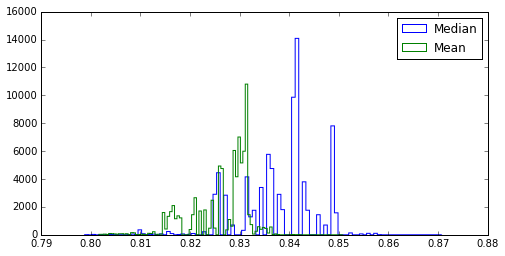

In [14]:
#for the color, we just find the median color of the top n stars in the RGB area
#ntip = 250
magsdown = 1
tipmagsA = emceemr.get_chain_by_name(modA, samplerA, 'tipmag')
crgb = c[rgbmsk].ravel()
mrgb = m[rgbmsk].ravel()
sorti = np.argsort(mrgb)
mrgb = mrgb[sorti]
crgb = crgb[sorti]
meds, means = [], []
for tm in tipmagsA.ravel():
    #topn = crgb[mrgb > tm][:ntip]
    topn = crgb[((tm+magsdown)>mrgb)&(mrgb > tm)]    
    meds.append(np.median(topn))
    means.append(np.mean(topn))

plt.figure(figsize=(8,4))
plt.hist(meds, bins=100, histtype='step', label='Median')
plt.hist(means, bins=100, histtype='step', label='Mean')
plt.legend()

tipcolorA = np.array(meds).reshape(tipmagsA.shape)

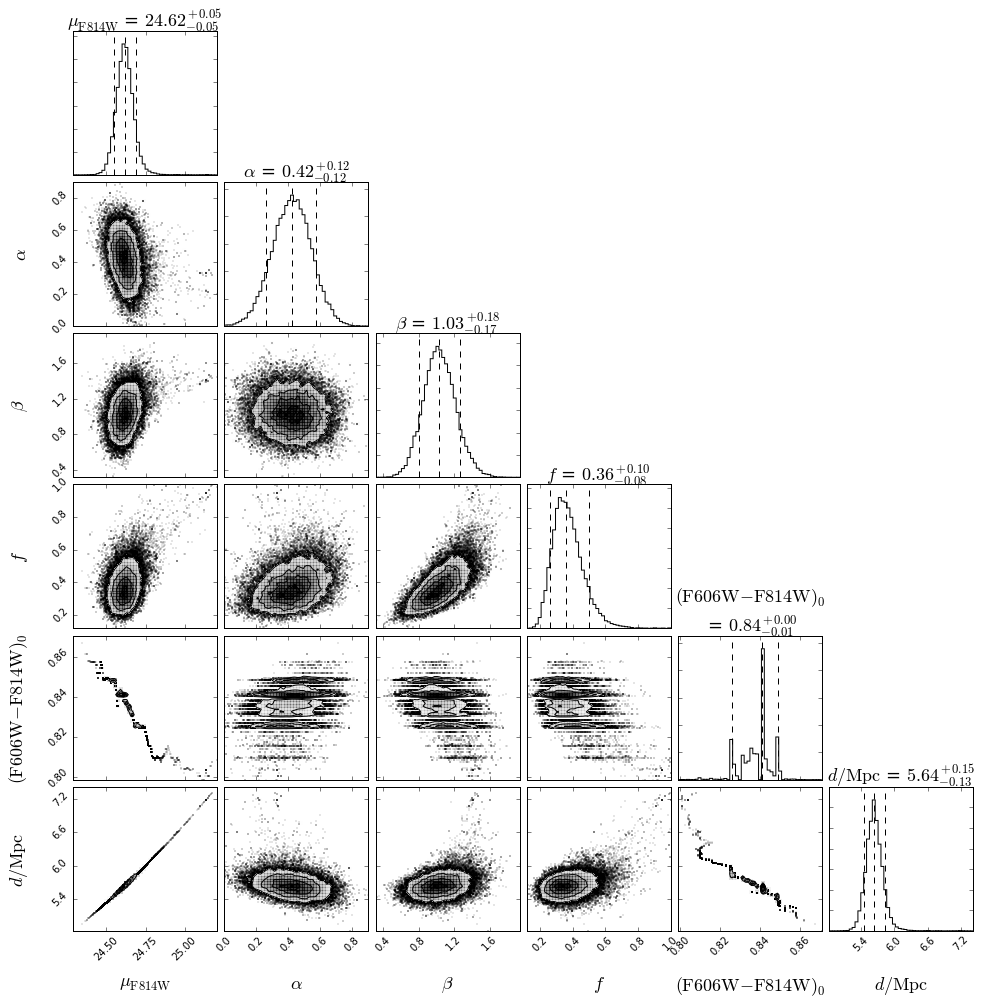

In [15]:
#now compute distance from Rizzi top of pg 13 for ACS F814W
rgb814_0 = -4.06+0.20*(tipcolorA-1.23) 
d_distrA = Distance(distmod=tipmagsA-rgb814_0)

emceemr.funcs.triangle_plot(modA, samplerA, quantiles=[.1, .5, .9], show_titles=True, 
                      chainstoadd=dict(tipcolor=tipcolorA.ravel(), 
                                       distance=d_distrA.Mpc.ravel()), 
                      relabel={'tipmag':r'$\mu_{\rm F814W}$',
                                     'alphargb':r'$\alpha$',
                                     'alphaother':r'$\beta$',
                                     'fracother':r'$f$',
                                     'tipcolor':r'$({\rm F606W-F814W})_0$'+'\n',
                                     'distance':r'$d/{\rm Mpc}$'},
                      verbose=False)

reprocess_triangle_for_pub(plt.gcf())
save_pub_figure('Pisc_A_corner')

# Pisc B

In [23]:
d = np.loadtxt('PiscB_dolphot/piscB')
wcs = WCS(fits.getheader('PiscB_dolphot/PiscB_F606W_drc.chip1.fits'))

#object is roughly here
x0 = 4250
y0 = 5900

#control area
xc = 3500
yc = 3000

sc0 = SkyCoord.from_pixel(x0, y0, wcs)
ebvmap = IrsaDust.get_images(sc0,2*u.degree, 'ebv')[0][0].data
ebv = ebvmap[ebvmap.shape[0]//2, ebvmap.shape[0]//2]
A606W = ebv*2.471 # from S & F 11
A814W = ebv*1.526 # from S & F 11
A606W, A814W

# only use good stars
ds = d[d[:, 10]<2]

m606 = ds[:,15] - A606W
m606e = ds[:,17]
m814 = ds[:,28] - A814W
m814e = ds[:,30]
dpx_dwarf = np.hypot(x0-ds[:,2],y0-ds[:,3])
dpx_control = np.hypot(xc-ds[:,2],yc-ds[:,3])

ce = np.hypot(m606e, m814e)
me = m814e
c = m606-m814
m = m814

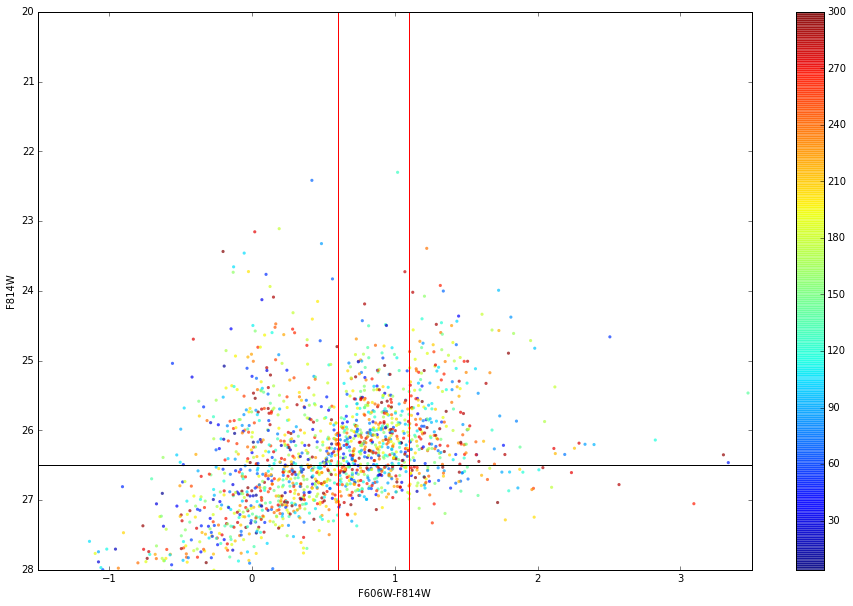

In [24]:
nearmsk = dpx_dwarf < 300

clims = (.6, 1.1)
mlim  = 26.5

plt.scatter(c[nearmsk], m[nearmsk], c=dpx_dwarf[nearmsk], s=10, edgecolor='none', alpha=.7)
plt.colorbar()
plt.xlim(-1.5, 3.5)
plt.ylim(28, 20)
plt.xlabel('F606W-F814W')
plt.ylabel('F814W')

for clim in clims:
    plt.axvline(clim, color='r')

plt.axhline(mlim, color='k')

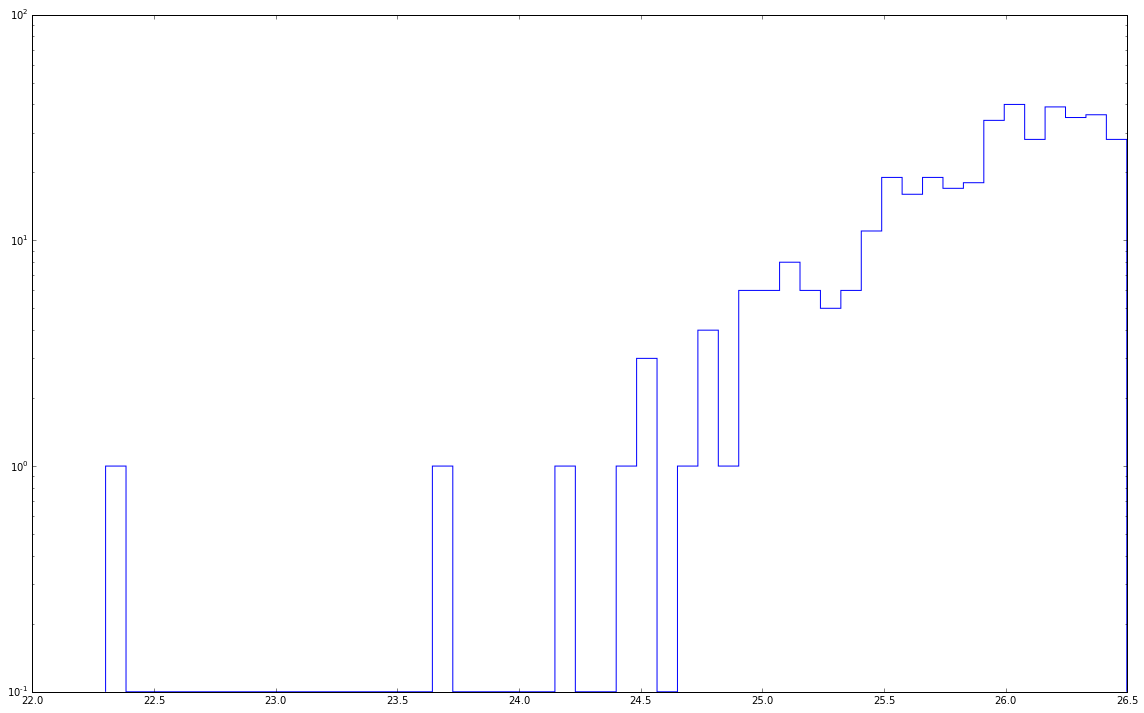

In [25]:
rgbmsk = nearmsk&(clims[0]<c)&(c<clims[1])&(m<mlim)&(m>20)
plt.hist(m[rgbmsk],bins=50, histtype='step',log=True)
plt.tight_layout()

## Baseline model with no uncfuncs/completeness 

Took 29.9101190567 sec
Acors:
tipmag: 70.5719044227
alphargb: 90.188546092
alphaother: 59.0075816904
fracother: 60.9147596179
Acceptance Fractions:
[ 0.4434,  0.4312,  0.4606,  0.4566,  0.4652,  0.438 ,  0.3168,  0.462 ,
  0.4824,  0.4132,  0.4886,  0.057 ,  0.5066,  0.5118,  0.5104,  0.4946]


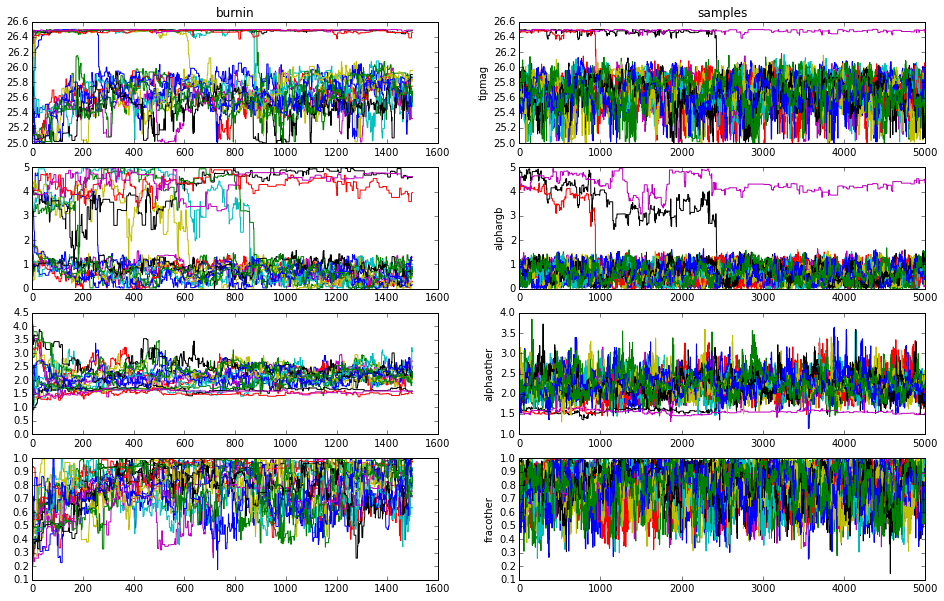

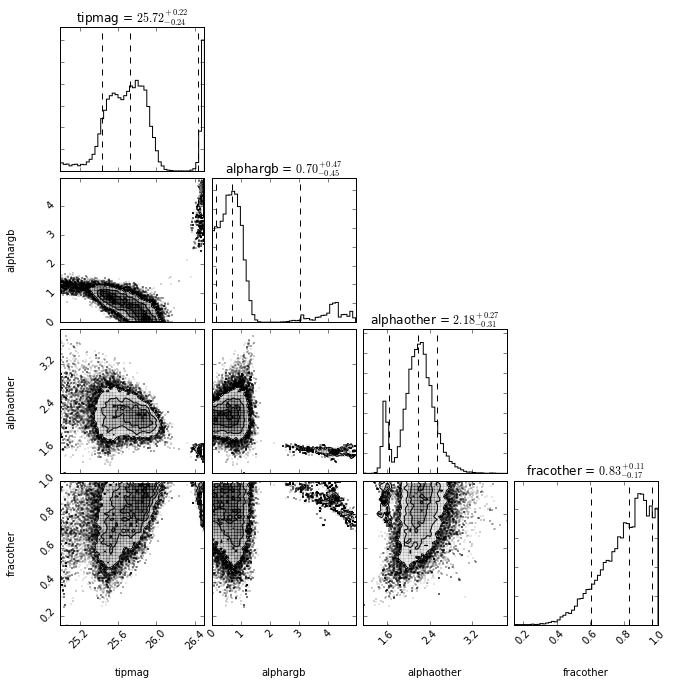

In [26]:
prisB_base = dict(tipmag=priors.UniformPrior(25, 26.5),
            #alphargb=priors.UniformPrior(0.2, 2.2),
             alphargb=priors.UniformPrior(0., 5),
             alphaother=priors.UniformPrior(0, 5),
             fracother=priors.UniformPrior(0,1))

modB_base = rgbmcmr.RGBModel(m[rgbmsk], me[rgbmsk], priors=prisB_base)

st = time.time()
samplerB_base = modB_base.initialize_and_sample(5000, burnin=1500)
et = time.time()
print('Took',et-st,'sec')

plt.figure()
emceemr.plot_chains(modB_base, samplerB_base)
plt.figure()
emceemr.triangle_plot(modB_base, samplerB_base, quantiles=[.1, .5, .9], show_titles=True, verbose=False)

print(emceemr.sampler_info_string(modB_base, samplerB_base))

## Try with the uncfunc approach 

In [27]:
#median absolute deviation from ASTs for piscA
madmodelB = modeling.models.Legendre1D(20, c0=394461317.10979784, c1=-145597820.62642878, c2=14956699.130353978, c3=-713036.8987249642, c4=15795.783970188611, c5=-66.67548994107459, c6=-2.5718562940123766, c7=-0.012567092851103162, c8=0.0010443650954728937, c9=1.4248780811847509e-05, c10=-2.9769679739652196e-07, c11=-1.0002176285392608e-08, c12=2.920121507961471e-11, c13=7.478998206297859e-12, c14=-8.29591303050837e-14, c15=-1.1449564824511707e-15, c16=7.328311870318666e-18, c17=6.402700451974091e-19, c18=-1.276065361237432e-20, c19=9.642762541452898e-23, c20=-2.718091289820745e-25)
uncfuncB = madmodelB.copy()
uncfuncB.parameters *= 1.483 # works only b/c polynomials are linear

def complfuncB(mag): #logistic function is a good fit to completeness
    x0=28.026095235356163
    w=-0.5204023249559749
    t = (mag-x0)/w
    return 1/(1+np.exp(-t))

def biasfuncB(mag):
    # get these from UnivariateSpline._eval_args
    spl_eval_args = (np.array([ 21.04,  21.04,  21.04,  21.04,  25.04,  27.04,  28.  ,  28.48,
         28.72,  28.96,  28.96,  28.96,  28.96]),
         np.array([ -3.54954266e-03,   3.79688149e-04,  -1.47134921e-02,
         -4.52460816e-02,  -3.48736930e-01,   7.44898654e-02,
          5.90351487e-01,   6.74639098e-01,   5.15202077e-01,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00]),
          3)
    return -interpolate.splev(mag, spl_eval_args)

In [20]:
prisB_uncfunc = dict(tipmag=priors.UniformPrior(25, 26.5),
            #alphargb=priors.UniformPrior(0, 5),
            alphargb=priors.NormalPrior(mu=np.log(10)*.3, sig=0.25, lower=0, upper=5),
            alphaother=priors.UniformPrior(0, 5),
            fracother=priors.UniformPrior(0,1))

modB_uncfunc = rgbmcmr.RGBModel(m[rgbmsk], priors=prisB_uncfunc,
                                funcmags=rgbmcmr.RGBModel.AutoFuncmags(21.005, 29, 0.125),
                                uncfunc=uncfuncB, biasfunc=biasfuncB, complfunc=complfuncB)

nthreads = 4
burnin = 1500
nsamples = 5000
len(modB_uncfunc.funcmags)  # useful because time to run scales with this

2302

In [21]:
#experimental timing run
nsample_test = 24
nburnin_test = 12
nall_test = nsample_test + nburnin_test
nall = burnin+nsamples

st = time.time()
modB_uncfunc.initialize_and_sample(nsample_test, burnin=nburnin_test, threads=nthreads)
et = time.time()
dt = (et - st)*u.second
    
print(nall_test, 'samples took', dt, 'which scales up to',nall,'samples in',(dt*nall/nall_test).to(u.minute))

36 samples took 13.6319010258 s which scales up to 6500 samples in 41.0219243831 min


Starting at 2015-12-15 15:13:04.336419
Took 2404.21070004 sec
Acors:
tipmag: 50.0985473552
alphargb: 49.7308922055
alphaother: 43.8357970215
fracother: 46.6467426879
Acceptance Fractions:
[ 0.5578,  0.5464,  0.5654,  0.5568,  0.562 ,  0.5622,  0.5492,  0.5416,
  0.5402,  0.5624,  0.5622,  0.5568,  0.5458,  0.5206,  0.5584,  0.5486]


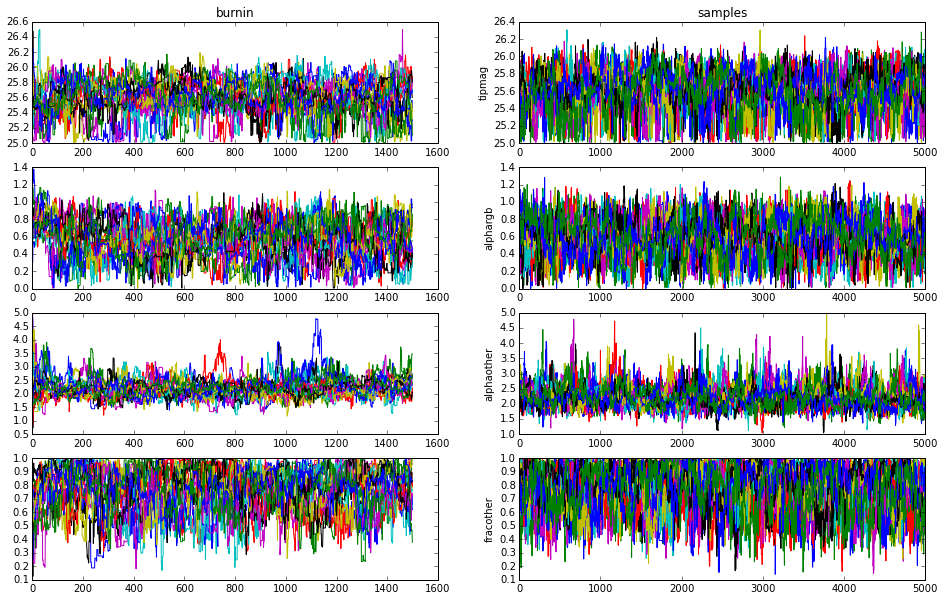

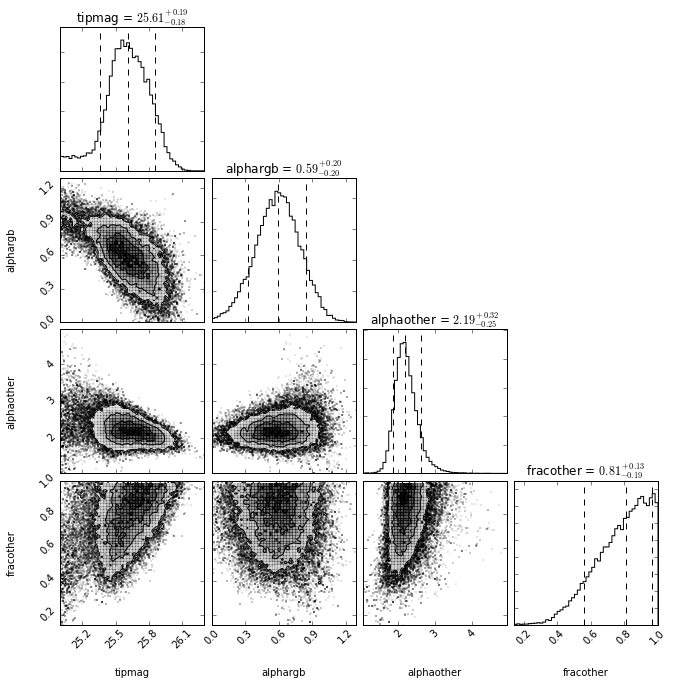

In [22]:
print('Starting at', datetime.datetime.now())
sys.stdout.flush()

st = time.time()
samplerB_uncfunc = modB_uncfunc.initialize_and_sample(nsamples, burnin=burnin, threads=nthreads)
et = time.time()
print('Took',et-st,'sec')

plt.figure()
emceemr.plot_chains(modB_uncfunc, samplerB_uncfunc)
plt.figure()
emceemr.triangle_plot(modB_uncfunc, samplerB_uncfunc, quantiles=[.1, .5, .9], show_titles=True, verbose=False)

print(emceemr.sampler_info_string(modB_uncfunc, samplerB_uncfunc))

In [23]:
# now we set the "baseline" names to be the uncfunc type so the stuff below works
modB = modB_uncfunc
samplerB = samplerB_uncfunc

## Color/distance 

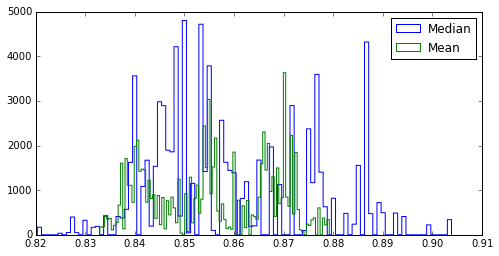

In [24]:
#for the color, we just find the median color of the top n stars in the RGB area
#ntip = 250
magsdown = 0.5
tipmagsB = emceemr.get_chain_by_name(modB, samplerB, 'tipmag')
crgb = c[rgbmsk].ravel()
mrgb = m[rgbmsk].ravel()
sorti = np.argsort(mrgb)
mrgb = mrgb[sorti]
crgb = crgb[sorti]
meds, means = [], []
for tm in tipmagsB.ravel():
    #topn = crgb[mrgb > tm][:ntip]
    topn = crgb[((tm+magsdown)>mrgb)&(mrgb > tm)]    
    meds.append(np.median(topn))
    means.append(np.mean(topn))

plt.figure(figsize=(8,4))
plt.hist(meds, bins=100, histtype='step', label='Median')
plt.hist(means, bins=100, histtype='step', label='Mean')
plt.legend()

tipcolorB = np.array(meds).reshape(tipmagsB.shape)

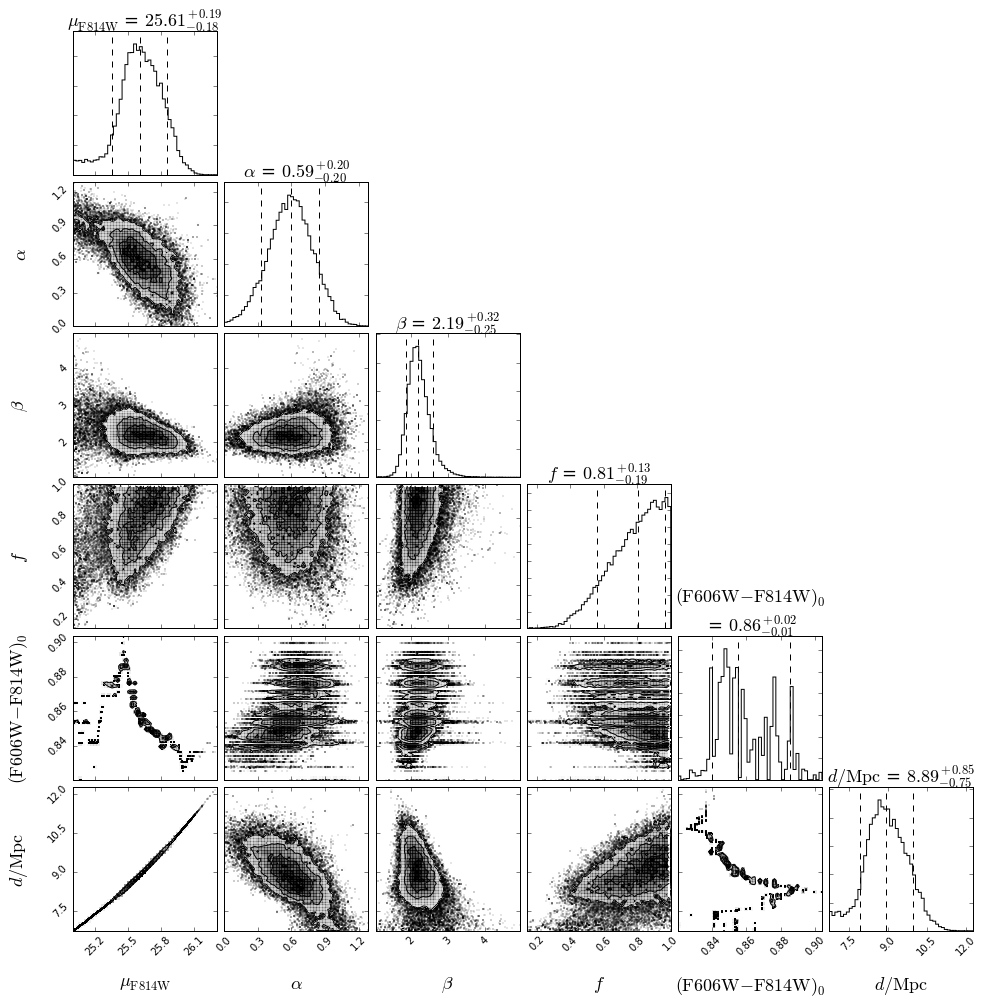

In [25]:
#now compute distance from Rizzi top of pg 13 for ACS F814W
rgb814_0 = -4.06+0.20*(tipcolorB-1.23) 
d_distrB = Distance(distmod=tipmagsB-rgb814_0)
emceemr.funcs.triangle_plot(modB, samplerB, quantiles=[.1, .5, .9], show_titles=True, 
                            chainstoadd=dict(tipcolor=tipcolorB.ravel(), distance=d_distrB.Mpc.ravel()), 
                            relabel={'tipmag':r'$\mu_{\rm F814W}$',
                                     'alphargb':r'$\alpha$',
                                     'alphaother':r'$\beta$',
                                     'fracother':r'$f$',
                                     'tipcolor':r'$({\rm F606W-F814W})_0$'+'\n',
                                     'distance':r'$d/{\rm Mpc}$'},
                            verbose=False)

reprocess_triangle_for_pub(plt.gcf())
save_pub_figure('Pisc_B_corner')

# Save Distance Results and Chains

In [26]:
datestamp = datetime.datetime.now().strftime('%Y_%m_%d')

In [27]:
np.savez('PiscAB_distances_{0}.npz'.format(datestamp), 
         piscA_dist_Mpc=d_distrA.Mpc, piscB_dist_Mpc=d_distrB.Mpc)

tosavedct = dict(modA=modA, modB=modB, chainsA=samplerA.chain, chainsB=samplerB.chain, param_names=modA.param_names)
np.savez('rgb_chains_{0}.npz'.format(datestamp), **tosavedct)

In [28]:
np.savez('PiscAB_distances_{0}.npz'.format(datestamp), 
         piscA_dist_Mpc=d_distrA.Mpc, piscB_dist_Mpc=d_distrB.Mpc)

tosavedct = dict(modA=modA, modB=modB, chainsA=samplerA.chain, chainsB=samplerB.chain, param_names=modA.param_names)
np.savez('rgb_chains_{0}.npz'.format(datestamp), **tosavedct)

# Distance nicer histograms

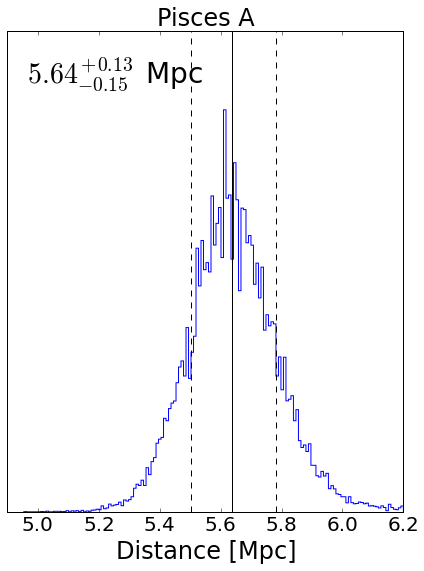

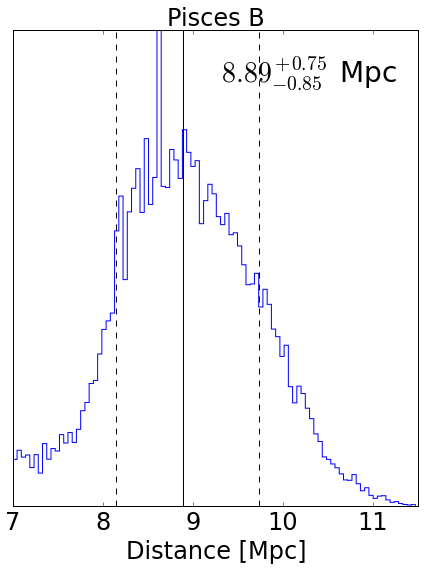

In [36]:
from astroML import plotting

def dist_hist(distr, xlims=None, bins='knuth', txtright=True):
    distr = distr.ravel().to(u.Mpc).value

    plotting.hist(distr, bins=bins, histtype='step', range=xlims)
    
    p16, p50, p84 = np.percentile(distr, [16, 50, 84])
    plt.axvline(p50, color='k')
    plt.axvline(p16, color='k', ls='dashed')
    plt.axvline(p84, color='k', ls='dashed')
    
    statsstr = r'${0:.2f}^<+{1:.2f}>_<{2:.2f}>$ Mpc'.format(p50,p50-p16,p50-p84).replace('<','{').replace('>','}')
    
    xtxt = 0.95 if txtright else 0.05
    ha = 'right' if txtright else 'left'
    plt.text(xtxt,0.95, statsstr, transform=plt.gca().transAxes, fontsize=28, ha=ha,va='top')
    
    if xlims is not None:
        plt.xlim(*xlims)
    plt.xlabel('Distance [Mpc]',fontsize=24)
    plt.xticks(fontsize=20)
    plt.yticks([])
    
    
plt.figure(figsize=(6,8))
dist_hist(d_distrA, (4.9,6.2), 'knuth',txtright=False)
plt.title('Pisces A', fontsize=24)
plt.tight_layout()
save_pub_figure('PiscA_dist')

plt.figure(figsize=(6,8))
dist_hist(d_distrB, (7,11.5), 'knuth')
plt.xticks([7,8,9,10,11], fontsize=24)
plt.title('Pisces B', fontsize=24)
plt.tight_layout()
save_pub_figure('PiscB_dist')

# Radial gradient checks

In [ ]:
bluebox = [-.4,.2,26,21.5]
redbox = [.5,1.2,26,24]

nearmsk = dpx_dwarf < 500

plt.scatter(c[nearmsk], m[nearmsk], s=10, edgecolor='none')
bluerect = plt.Rectangle((bluebox[0],bluebox[2]),bluebox[1]-bluebox[0],bluebox[3]-bluebox[2], facecolor='none', edgecolor='blue')
redrect = plt.Rectangle((redbox[0],redbox[2]),redbox[1]-redbox[0],redbox[3]-redbox[2], facecolor='none', edgecolor='red')
plt.gca().add_patch(bluerect)
plt.gca().add_patch(redrect)

plt.xlim(-1, 2)
plt.ylim(27, 20)

In [ ]:
bluemsk = (bluebox[0]<c)&(c<bluebox[1])&(bluebox[3]<m)&(m<bluebox[2])
redmsk = (redbox[0]<c)&(c<redbox[1])&(redbox[3]<m)&(m<redbox[2])
np.sum(bluemsk), np.sum(redmsk)

In [ ]:
plotting.hist(dpx_dwarf[bluemsk], bins=30, normed=True, color='b', histtype='step', range=(0,500))
plotting.hist(dpx_dwarf[redmsk], bins=30, normed=True, color='r', histtype='step', range=(0,500))
plt.tight_layout()

In [ ]:
for c, px1, px2 in zip(cs, px[:-1], px[1:])
    nearmsk = dpx_dwarf < 500
    plt.scatter(c[nearmsk], m[nearmsk], s=10, edgecolor='none')
plt.xlim(-1, 2)
plt.ylim(27, 20)

# Run the below to load what was saved above into the namespace 

In [18]:
class FakeSampler(object):
    def __init__(self, chains):
        self.chain = chains
        
    @property
    def flatchain(self):
        """
        A shortcut for accessing chain flattened along the zeroth (walker)
        axis.

        """
        s = self.chain.shape
        return self.chain.reshape(s[0] * s[1], s[2])

def fakefunc():
    raise NotImplementedError
    
biasfuncA = fakefunc
biasfuncB = fakefunc

In [19]:
res = np.load('rgb_chains_2015_12_15.npz')
for k in res.keys():
    print("Loading", k)
    if res[k].dtype == np.object and len(res[k].shape) == 0:
        globals()[k] = res[k].ravel()[0]
    else:
        globals()[k] = res[k]

Loading chainsA
Loading param_names
Loading modB
Loading chainsB
Loading modA


In [20]:
samplerA = FakeSampler(chainsA)
samplerB = FakeSampler(chainsB)

## Now try to reproduce some plots with a bit of trickery

Need to run the Pisc A prep stuff (up to defining the samplers)!

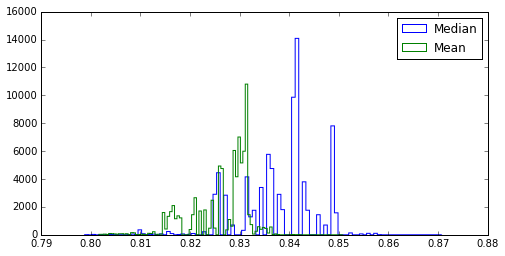

In [21]:
#for the color, we just find the median color of the top n stars in the RGB area
#ntip = 250
magsdown = 1
tipmagsA = emceemr.get_chain_by_name(modA, samplerA, 'tipmag')
crgb = c[rgbmsk].ravel()
mrgb = m[rgbmsk].ravel()
sorti = np.argsort(mrgb)
mrgb = mrgb[sorti]
crgb = crgb[sorti]
meds, means = [], []
for tm in tipmagsA.ravel():
    #topn = crgb[mrgb > tm][:ntip]
    topn = crgb[((tm+magsdown)>mrgb)&(mrgb > tm)]    
    meds.append(np.median(topn))
    means.append(np.mean(topn))

plt.figure(figsize=(8,4))
plt.hist(meds, bins=100, histtype='step', label='Median')
plt.hist(means, bins=100, histtype='step', label='Mean')
plt.legend()

tipcolorA = np.array(meds).reshape(tipmagsA.shape)

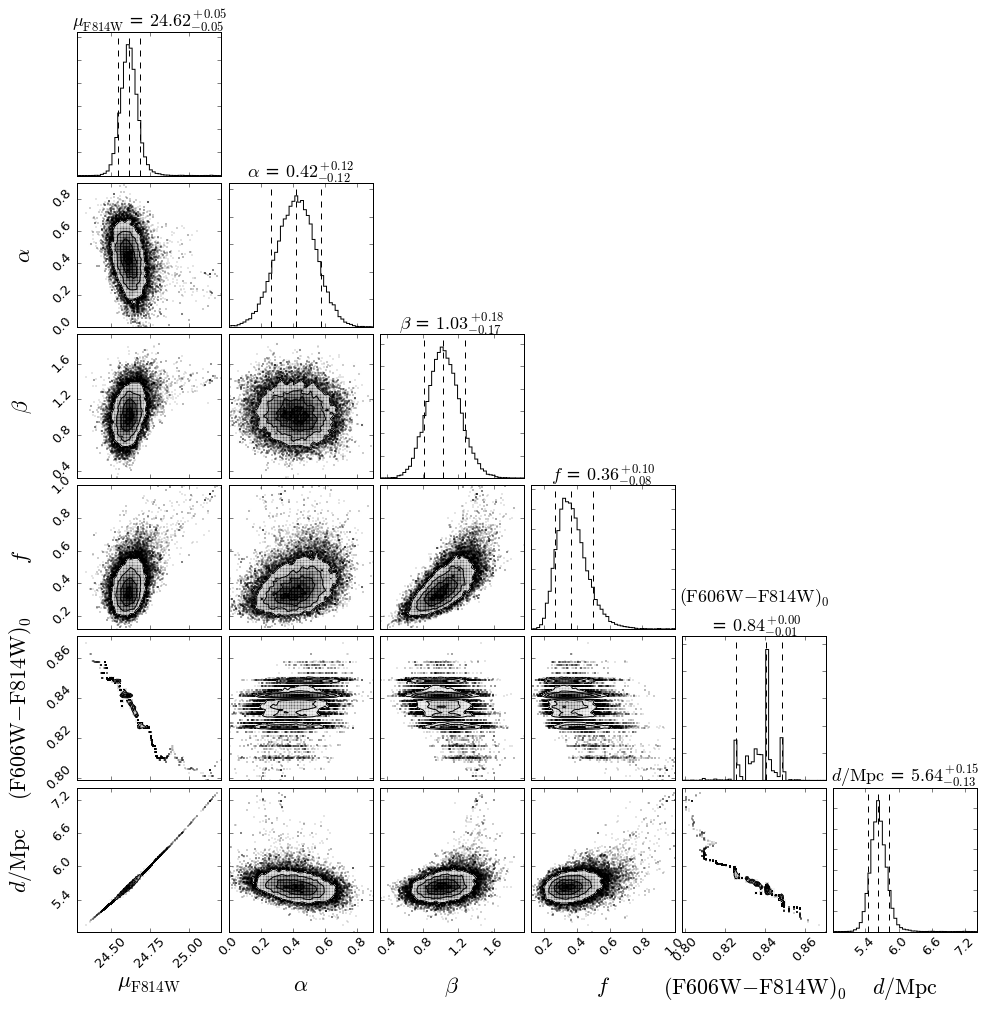

In [22]:
#now compute distance from Rizzi top of pg 13 for ACS F814W
rgb814_0 = -4.06+0.20*(tipcolorA-1.23) 
d_distrA = Distance(distmod=tipmagsA-rgb814_0)

emceemr.funcs.triangle_plot(modA, samplerA, quantiles=[.1, .5, .9], show_titles=True, 
                      chainstoadd=dict(tipcolor=tipcolorA.ravel(), 
                                       distance=d_distrA.Mpc.ravel()), 
                      relabel={'tipmag':r'$\mu_{\rm F814W}$',
                                     'alphargb':r'$\alpha$',
                                     'alphaother':r'$\beta$',
                                     'fracother':r'$f$',
                                     'tipcolor':r'$({\rm F606W-F814W})_0$'+'\n',
                                     'distance':r'$d/{\rm Mpc}$'},
                      verbose=False)

reprocess_triangle_for_pub(plt.gcf(), tcklabelsize=13, titlesize=18, labelsize=22)
save_pub_figure('Pisc_A_corner_bigtcks')

Need to run the Pisc B prep stuff (up to defining the samplers)!

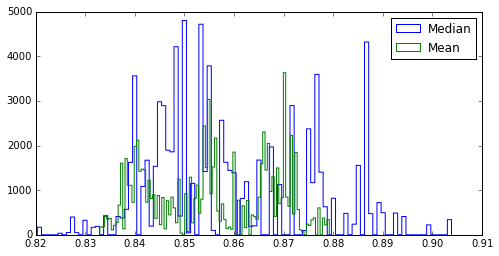

In [28]:
#for the color, we just find the median color of the top n stars in the RGB area
#ntip = 250
magsdown = 0.5
tipmagsB = emceemr.get_chain_by_name(modB, samplerB, 'tipmag')
crgb = c[rgbmsk].ravel()
mrgb = m[rgbmsk].ravel()
sorti = np.argsort(mrgb)
mrgb = mrgb[sorti]
crgb = crgb[sorti]
meds, means = [], []
for tm in tipmagsB.ravel():
    #topn = crgb[mrgb > tm][:ntip]
    topn = crgb[((tm+magsdown)>mrgb)&(mrgb > tm)]    
    meds.append(np.median(topn))
    means.append(np.mean(topn))

plt.figure(figsize=(8,4))
plt.hist(meds, bins=100, histtype='step', label='Median')
plt.hist(means, bins=100, histtype='step', label='Mean')
plt.legend()

tipcolorB = np.array(meds).reshape(tipmagsB.shape)

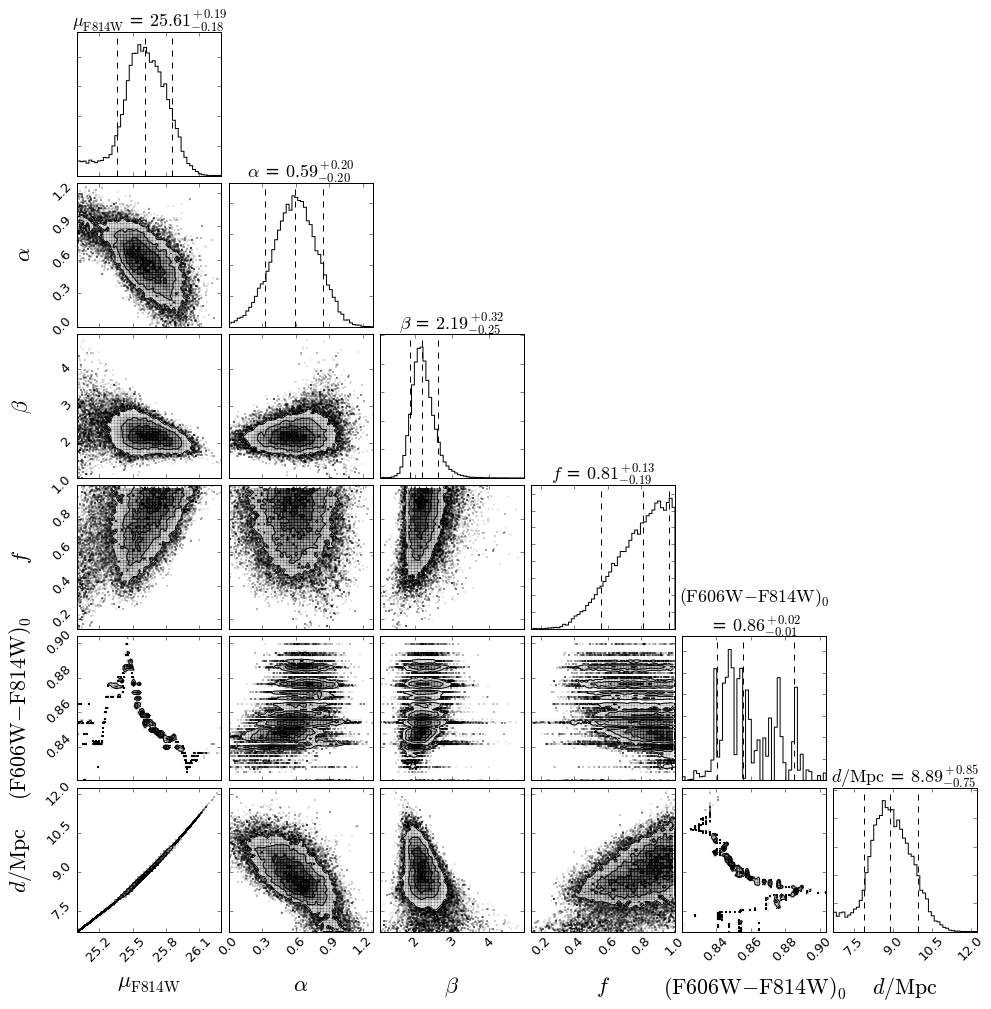

In [29]:
#now compute distance from Rizzi top of pg 13 for ACS F814W
rgb814_0 = -4.06+0.20*(tipcolorB-1.23) 
d_distrB = Distance(distmod=tipmagsB-rgb814_0)
emceemr.funcs.triangle_plot(modB, samplerB, quantiles=[.1, .5, .9], show_titles=True, 
                            chainstoadd=dict(tipcolor=tipcolorB.ravel(), distance=d_distrB.Mpc.ravel()), 
                            relabel={'tipmag':r'$\mu_{\rm F814W}$',
                                     'alphargb':r'$\alpha$',
                                     'alphaother':r'$\beta$',
                                     'fracother':r'$f$',
                                     'tipcolor':r'$({\rm F606W-F814W})_0$'+'\n',
                                     'distance':r'$d/{\rm Mpc}$'},
                            verbose=False)

reprocess_triangle_for_pub(plt.gcf(), tcklabelsize=13, titlesize=18, labelsize=22)
save_pub_figure('Pisc_B_corner_bigtcks')

## Check Biasfunc effect

In [12]:
#median absolute deviation from ASTs for piscA
madmodelB = modeling.models.Legendre1D(20, c0=394461317.10979784, c1=-145597820.62642878, c2=14956699.130353978, c3=-713036.8987249642, c4=15795.783970188611, c5=-66.67548994107459, c6=-2.5718562940123766, c7=-0.012567092851103162, c8=0.0010443650954728937, c9=1.4248780811847509e-05, c10=-2.9769679739652196e-07, c11=-1.0002176285392608e-08, c12=2.920121507961471e-11, c13=7.478998206297859e-12, c14=-8.29591303050837e-14, c15=-1.1449564824511707e-15, c16=7.328311870318666e-18, c17=6.402700451974091e-19, c18=-1.276065361237432e-20, c19=9.642762541452898e-23, c20=-2.718091289820745e-25)
uncfuncB = madmodelB.copy()
uncfuncB.parameters *= 1.483 # works only b/c polynomials are linear
def complfuncB(mag): #logistic function is a good fit to completeness
    x0=28.026095235356163
    w=-0.5204023249559749
    t = (mag-x0)/w
    return 1/(1+np.exp(-t))

def biasfuncB(mag):
    # get these from UnivariateSpline._eval_args
    spl_eval_args = (np.array([ 21.04,  21.04,  21.04,  21.04,  25.04,  27.04,  28.  ,  28.48,
         28.72,  28.96,  28.96,  28.96,  28.96]),
         np.array([ -3.54954266e-03,   3.79688149e-04,  -1.47134921e-02,
         -4.52460816e-02,  -3.48736930e-01,   7.44898654e-02,
          5.90351487e-01,   6.74639098e-01,   5.15202077e-01,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00]),
          3)
    return -interpolate.splev(mag, spl_eval_args)

In [12]:
prisB_uncfunc = dict(tipmag=priors.UniformPrior(25, 26.5),
            #alphargb=priors.UniformPrior(0, 5),
            alphargb=priors.NormalPrior(mu=np.log(10)*.3, sig=0.25, lower=0, upper=5),
            alphaother=priors.UniformPrior(0, 5),
            fracother=priors.UniformPrior(0,1))

modB_uncfunc = rgbmcmr.RGBModel(m[rgbmsk], priors=prisB_uncfunc,
                                funcmags=rgbmcmr.RGBModel.AutoFuncmags(21.005, 29, 0.5),
                                uncfunc=uncfuncB, biasfunc=biasfuncB, complfunc=complfuncB)

nthreads = 4
burnin = 1000
nsamples = 2000
len(modB_uncfunc.funcmags)  # useful because time to run scales with this

579

In [13]:
#experimental timing run
nsample_test = 24
nburnin_test = 12
nall_test = nsample_test + nburnin_test
nall = burnin+nsamples

st = time.time()
sampler = modB_uncfunc.initialize_and_sample(nsample_test, burnin=nburnin_test, threads=nthreads)
et = time.time()
dt = (et - st)*u.second
    
print(nall_test, 'samples took', dt, 'which scales up to',nall,'samples in',(dt*nall/nall_test).to(u.minute))

36 samples took 3.10015916824 s which scales up to 3000 samples in 4.30577662256 min


Starting at 2015-12-15 13:47:34.641474
Took 235.307155848 sec
Acors:
tipmag: 47.1067452785
alphargb: 44.9404627948
alphaother: 58.4949310687
fracother: 54.8528125669
Acceptance Fractions:
[ 0.5395,  0.5515,  0.565 ,  0.545 ,  0.5725,  0.537 ,  0.5595,  0.5485,
  0.543 ,  0.5495,  0.5195,  0.535 ,  0.564 ,  0.549 ,  0.562 ,  0.5585]


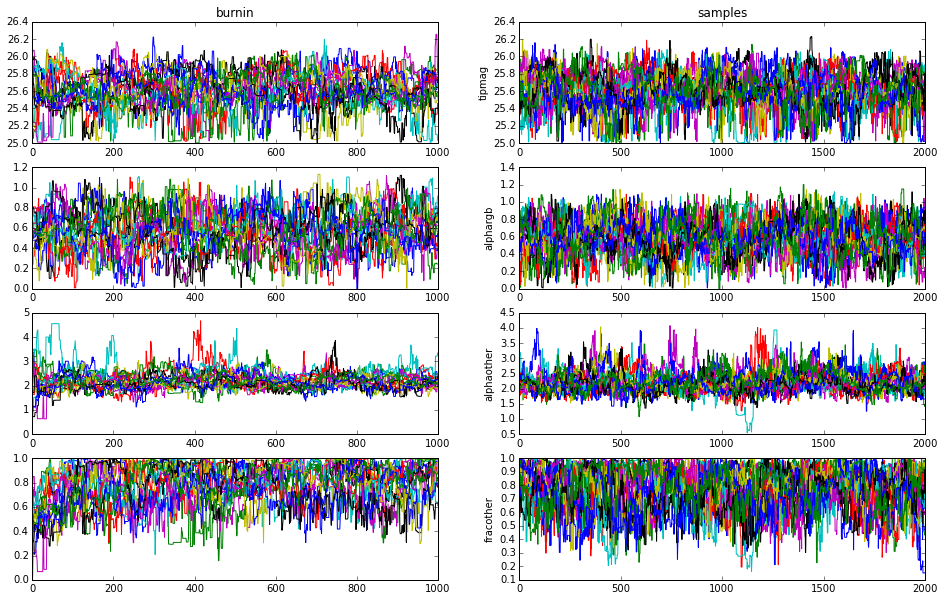

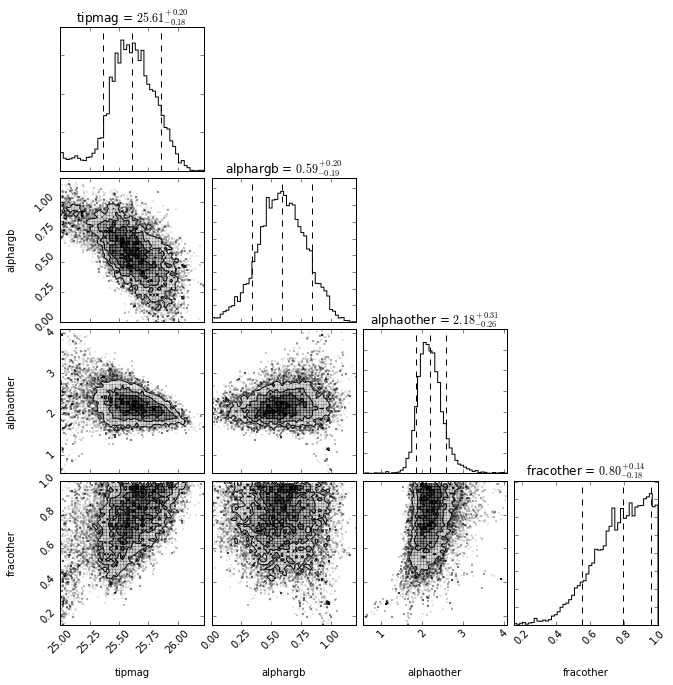

In [14]:
print('Starting at', datetime.datetime.now())
sys.stdout.flush()

st = time.time()
samplerB_uncfunc = modB_uncfunc.initialize_and_sample(nsamples, burnin=burnin, threads=nthreads)
et = time.time()
print('Took',et-st,'sec')

plt.figure()
emceemr.plot_chains(modB_uncfunc, samplerB_uncfunc)
plt.figure()
emceemr.triangle_plot(modB_uncfunc, samplerB_uncfunc, quantiles=[.1, .5, .9], show_titles=True, verbose=False)

print(emceemr.sampler_info_string(modB_uncfunc, samplerB_uncfunc))

In [20]:
#same for PiscA

In [21]:
#median absolute deviation from ASTs for piscA
madmodelA = modeling.models.Legendre1D(20, c0=-3954355396.3633738, c1=1353694208.4087687, c2=-124848799.79526304, c3=4897226.378521032, c4=-57041.00249220571, c5=-1549.1100474853888, c6=30.190195895799725, c7=1.1368681316643618, c8=-0.03563103282644921, c9=6.0712498989515646e-05, c10=4.892644246415783e-06, c11=8.248737934921185e-08, c12=-2.3350690477921424e-09, c13=-1.8352224226398223e-11, c14=5.350673251357965e-13, c15=2.4468515243894513e-15, c16=2.6121935517894807e-17, c17=-4.622081469223215e-18, c18=8.23871918441632e-20, c19=-6.005849952016176e-22, c20=1.6539943309668438e-24)
uncfuncA = madmodelA.copy()
uncfuncA.parameters *= 1.483 # works only b/c polynomials are linear

def complfuncA(mag): #logistic function is a good fit to completeness
    x0=28.11463766268196
    w=-0.546193490253588
    t = (mag-x0)/w
    return 1/(1+np.exp(-t))

def biasfuncA(mag):
    # get these from UnivariateSpline._eval_args
    spl_eval_args = (np.array([ 21.04,  21.04,  21.04,  21.04,  25.04,  27.04,  28.  ,  28.24,
                     28.48,  28.64,  28.72,  28.96,  28.96,  28.96,  28.96]),
                     np.array([  2.27431926e-04,  -1.32821783e-02,   2.46137242e-03,
                     -6.86495474e-02,  -3.29464037e-01,   2.55491886e-03,
                      1.95396586e-02,   3.14164071e-01,   4.38917629e-01,
                      1.50361261e+00,   5.16925592e+00,   0.00000000e+00,
                      0.00000000e+00,   0.00000000e+00,   0.00000000e+00]),
                      3)
    return -interpolate.splev(mag, spl_eval_args)

In [26]:
pris = dict(tipmag=priors.UniformPrior(23, 25.5),
            alphargb=priors.UniformPrior(0, 3), 
            alphaother=priors.UniformPrior(0, 3),
            fracother=priors.UniformPrior(0,1))

modA_uncfunc = rgbmcmr.RGBModel(m[rgbmsk], priors=pris,
                                funcmags=rgbmcmr.RGBModel.AutoFuncmags(21.005, 29, 0.5),
                                uncfunc=uncfuncA, biasfunc=biasfuncA, complfunc=complfuncA)

nthreads = 4
burnin = 1000
nsamples = 2000
len(modA_uncfunc.funcmags)  # useful because time to run scales with this

598

In [27]:
#experimental timing run
nsample_test = 24
nburnin_test = 12
nall_test = nsample_test + nburnin_test
nall = burnin+nsamples

st = time.time()
sampler = modA_uncfunc.initialize_and_sample(nsample_test, burnin=nburnin_test, threads=nthreads)
et = time.time()
dt = (et - st)*u.second
    
print(nall_test, 'samples took', dt, 'which scales up to',nall,'samples in',(dt*nall/nall_test).to(u.minute))

36 samples took 3.56281805038 s which scales up to 3000 samples in 4.94835840331 min


Starting at 2015-12-15 14:00:35.999867
Took 360.151118994 sec
Acors:
tipmag: 56.3900794846
alphargb: 34.130361284
alphaother: 41.801026538
fracother: 43.0145687336
Acceptance Fractions:
[ 0.5785,  0.5735,  0.5795,  0.5615,  0.5755,  0.571 ,  0.5895,  0.559 ,
  0.567 ,  0.585 ,  0.5785,  0.583 ,  0.5895,  0.5695,  0.59  ,  0.573 ]


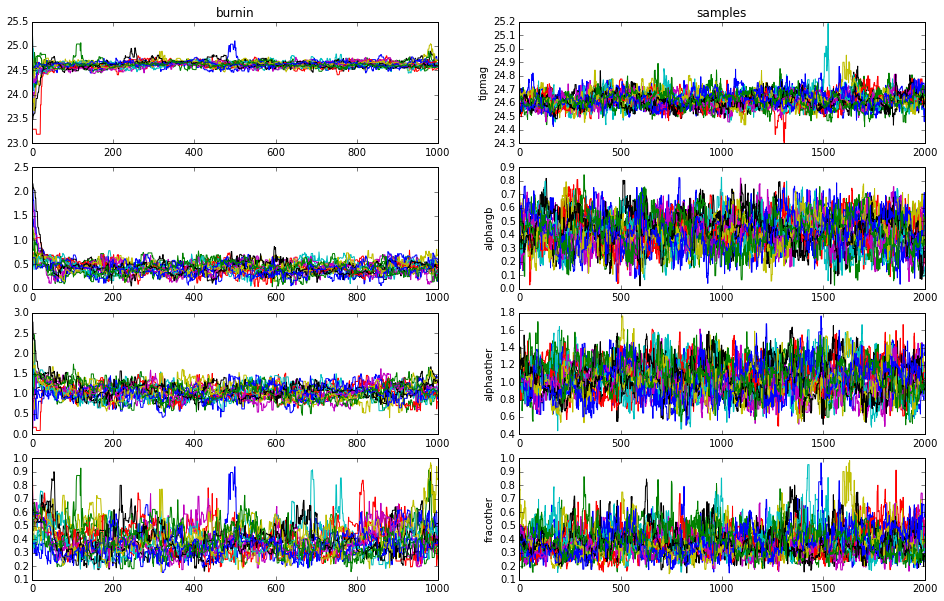

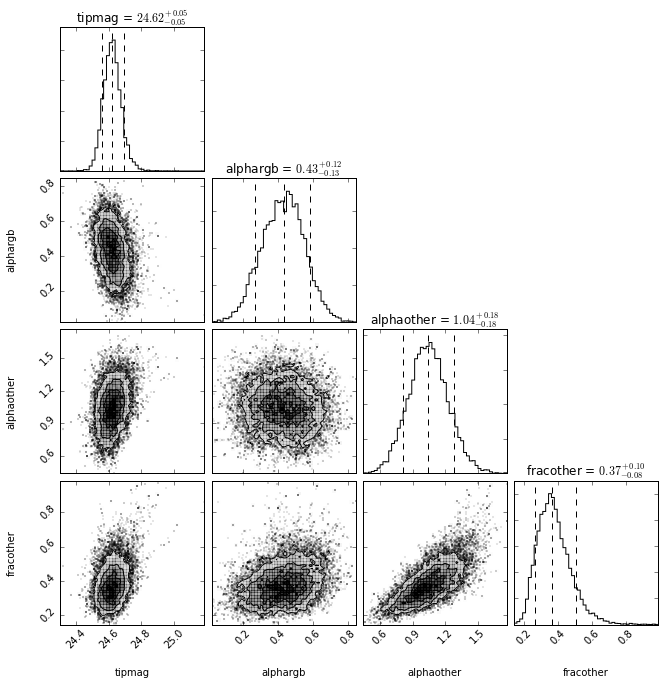

In [28]:
print('Starting at', datetime.datetime.now())
sys.stdout.flush()

st = time.time()
samplerA_uncfunc = modA_uncfunc.initialize_and_sample(nsamples, burnin=burnin, threads=nthreads)
et = time.time()
print('Took',et-st,'sec')

plt.figure()
emceemr.plot_chains(modA_uncfunc, samplerA_uncfunc)
plt.figure()
emceemr.triangle_plot(modA_uncfunc, samplerA_uncfunc, quantiles=[.1, .5, .9], show_titles=True, verbose=False)

print(emceemr.sampler_info_string(modA_uncfunc, samplerA_uncfunc))

In [29]:
#now the same but no biasfunc
modA_uncfunc._biasfunc = None

In [30]:
#experimental timing run
nsample_test = 24
nburnin_test = 12
nall_test = nsample_test + nburnin_test
nall = burnin+nsamples

st = time.time()
sampler = modA_uncfunc.initialize_and_sample(nsample_test, burnin=nburnin_test, threads=nthreads)
et = time.time()
dt = (et - st)*u.second
    
print(nall_test, 'samples took', dt, 'which scales up to',nall,'samples in',(dt*nall/nall_test).to(u.minute))

36 samples took 4.58767604828 s which scales up to 3000 samples in 6.37177228928 min


Starting at 2015-12-15 14:06:44.280528
Took 374.038972139 sec
Acors:
tipmag: 52.0572124421
alphargb: 33.2441169133
alphaother: 40.8700372646
fracother: 47.9722241563
Acceptance Fractions:
[ 0.58  ,  0.6085,  0.5805,  0.579 ,  0.5915,  0.574 ,  0.5865,  0.5735,
  0.5715,  0.5925,  0.5685,  0.5935,  0.5885,  0.5675,  0.5885,  0.581 ]


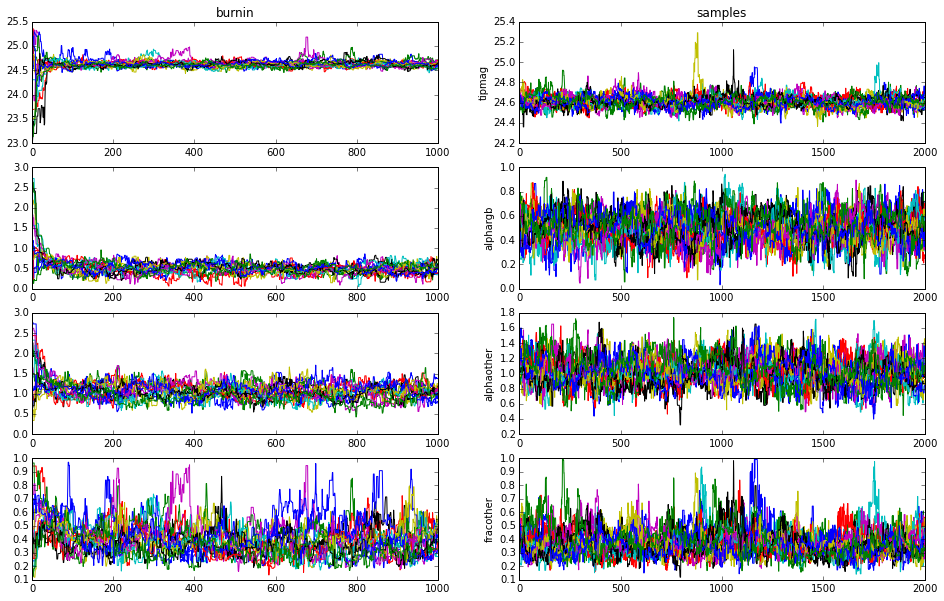

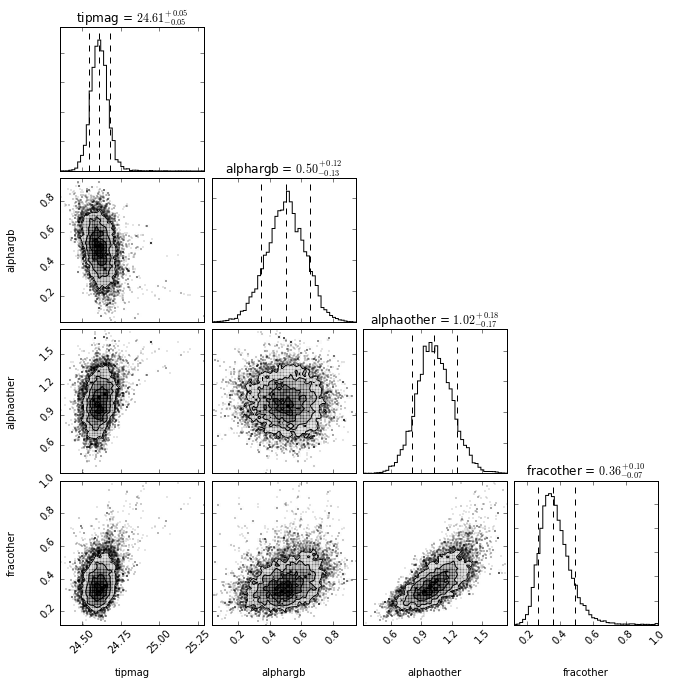

In [31]:
print('Starting at', datetime.datetime.now())
sys.stdout.flush()

st = time.time()
samplerA_uncfunc = modA_uncfunc.initialize_and_sample(nsamples, burnin=burnin, threads=nthreads)
et = time.time()
print('Took',et-st,'sec')

plt.figure()
emceemr.plot_chains(modA_uncfunc, samplerA_uncfunc)
plt.figure()
emceemr.triangle_plot(modA_uncfunc, samplerA_uncfunc, quantiles=[.1, .5, .9], show_titles=True, verbose=False)

print(emceemr.sampler_info_string(modA_uncfunc, samplerA_uncfunc))